<a href="https://colab.research.google.com/github/caavila96/Informalidad_GEIH_2022/blob/main/informalidad_GEIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto para la estimación de los determinantes de la informalidad laboral en Colombia.**

Para la generación de este proyecto se usará la base de datos de la Gran Encuesta Integrada de Hogares - GEIH 2022, esta base de datos es publicada por el Departamento Administrativo Nacional de Estadísticas - DANE de forma mensual (anonimizada) en diversos formatos.

Teniendo en cuenta esto se han subido los 12 meses a un respositorio en Github en formato .zip, cada uno de los formatos contiene un total de 9 tablas, a saber

*   Características generales, seguridad social en salud y educación 
*   Datos del hogar y la vivienda.
*   Fuerza de trabajo
*   Migración 
*   No ocupados
*   Ocupados
*   Otras formas de trabajo
*   Otros ingresos e impuestos
*   Tipo de investigación

Dado el objetivo de la investigación solo se tendran en cuenta tres bases, a saber:

*   Características generales, seguridad social en salud y educación 
*   Datos del hogar y la vivienda.
*   Fuerza de trabajo
*   Ocupados





## **1. Librerias a ser utilizadas**

En este capítulo se instalan e importan las librerias necesarias para el desarrollo del notebook

In [ ]:
!apt-get install git -y
!pip install geopandas
!pip install wget

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.11).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import requests #Descargar información Github
import io       #Herramientas principales para trabajar con streams
from zipfile import ZipFile #Apertura de los zip file
from functools import reduce #Usado para pegar las tablas
import gc #Limpiar memoria
import matplotlib.font_manager as fm # Manejo de fuentes
import matplotlib
import geopandas as gpd #Mapas
import wget # Descarga archivos 
import matplotlib.colors as mcolors #Colores de las gráficas

import warnings
warnings.filterwarnings("ignore", category=UnicodeWarning) #ignorar erroes de UTF-8 y Latin-1
warnings.filterwarnings("ignore") 

## **2. Impotar información y filtro inicial de variables.**

Para ello se descarga cada uno de los meses se hace el pegue de las bases, se gudarda en el disco temporal y posteriormente se unen los 12 meses. Para que la salida final no genera una base de datos tan pesada se creará una lista (collist) la cual contendrá las variables seleccionadas para el presente análisis. 

In [ ]:

#Se crea una lista vacía para guardar la base por cada mes
year = []
#Se crea una lista con los meses del 01 hasta el 12 string
month = []
for i in range(1, 13):
  month.append(str(i).zfill(2))

for m in month:

  #url de Github donde se encuentran los datos
  url = " https://github.com/caavila96/Informalidad_GEIH_2022/blob/33c817cad9cc205dbb6ebd8f935b2c2e1612bd14/BASE/"+ m + ".zip?raw=true"


  # Descarga de los datos de Github
  response = requests.get(url)
  data = io.BytesIO(response.content)

  # Se define una lista que contiene los nombres de las tablas que serán utilizadas
  tables = ['Características generales, seguridad social en salud y educación.dta',
                    'Datos del hogar y la vivienda.dta',
                    'Fuerza de trabajo.dta',
                    'Migración.dta',
                    'Ocupados.dta']

  # Se crea una lista donde se cargaran todas las tablas definidas
  dfs = []

  # Se extraen todos los datos definidos en la lista tables
  with ZipFile(data, "r") as zip_ref:
      for file in zip_ref.namelist():
          if any(file.endswith(f) for f in tables):
              with zip_ref.open(file) as f:
                  df = pd.read_stata(f, convert_categoricals=False)
                  df.columns = df.columns.str.upper()
                  df["MES"] = m
                  dfs.append(df)

  ##Se crea una lista de data frames con las bases de persona
  p_df =[df for j, df in enumerate(dfs) if j != 1]

  #Se realiza el pegue de las bases a nivel de persona, se crea un sufijo para eliminar las variables duplicadas
  p_df = reduce(lambda df1,df2: pd.merge(df1,df2,on=["DIRECTORIO","SECUENCIA_P","ORDEN"], how = "left",suffixes=('', '_remove')),  [df for j, df in enumerate(dfs) if j != 1])

  # Se realiza el pegue de las bases de personas con la base de vivienda y hogares
  t_df = pd.merge(p_df,dfs[1],on=["DIRECTORIO","SECUENCIA_P"], how = "left",suffixes=('', '_remove'))

  #Se remueven las variables duplicadas
  t_df.drop([i for i in t_df.columns if 'remove' in i],
                axis=1, inplace=True)
  
  #Se realiza el filtro de la lista de variable seleccionadas
  collist = ["DIRECTORIO","SECUENCIA_P","ORDEN","MES","CLASE","AREA","DPTO","P3271","P6040","P6050","P6080", "P3042","P3042S1","P3043","OCI",
 "P3069","P6426","OFICIO_C8","P6430","RAMA2D_R4","P3045S1","P3046","P3069","P3065","P3066","P6765","OFICIO_C8","P3067",
 "P3067S1","P3067S2","P6775","P3068","P6100","P6110","P6450","P6920","P6930","P6940","P3373","P3373S3","P3373S3A1",
 "P3373S3A2","P3382","P3382S3","P3384","P3384S3","FEX_C18"]
 
  t_df = t_df.filter(items = collist, axis = 1)

  #Se guarda la base de datos en la lista 
  year.append(t_df)

#Se crea una función para unir todas las tablas teniendo en cuenta el nombre de la variable
def unionByName(df1, df2):
    common_cols = df1.columns.intersection(df2.columns)
    combined_df = pd.concat([df1[common_cols], df2[common_cols]], ignore_index=True)
    return combined_df

# Se aplica a toda la lista de años 
df_final  = reduce(unionByName, year)

# Se elimina la lista de años y se limpia la memoria RAM
del year
gc.collect()

1412351

In [ ]:
#Cantidad de observaciones y expansión
df_final.groupby(["MES"]).agg(TOT_PER = ('DIRECTORIO', 'count'), 
                              TOT_PER_EXP = ('FEX_C18', 'sum'))

,TOT_PER,TOT_PER_EXP
MES,,
01,80116,50254112.0
02,79783,50299304.0
03,78595,50339835.0
04,77679,50384974.0
05,77380,50428727.0
06,77999,50474569.0
07,75963,50513027.0
08,76625,50559226.0
09,75382,50605026.0


## **3. Ajuste de variables y filtro de observaciones.**

Si bien se ha generado un filtro inicial de las variables es necesario realizar una serie de transformaciones para algunas de las variable, los primero que se realizará es el ajuste de los formatos de las variables, posteriormente se generaran variables a nivel de hogar variables compuestas (informalidad, años de educación) para posteriomente generar el filtro de observaciones y variables para tener la base final.

### 3.1 Ajuste de formatos. 

Los formatos se deben ajustar dado que durante la importación muchos de los valores que son int son float. Por este motivo se debe realizar este ajuste

In [ ]:
# dtypes iniciales
df_final.dtypes

DIRECTORIO     float64
SECUENCIA_P    float64
ORDEN          float64
MES             object
CLASE           object
AREA            object
DPTO            object
P3271          float64
P6040          float64
P6050          float64
P6080          float64
P3042          float64
P3042S1        float64
P3043          float64
OCI            float64
P3069          float64
P3069          float64
P6426          float64
OFICIO_C8       object
OFICIO_C8       object
P6430          float64
RAMA2D_R4       object
P3045S1        float64
P3046          float64
P3065          float64
P3066          float64
P6765          float64
P3067          float64
P3067S1        float64
P3067S2        float64
P6775          float64
P3068          float64
P6100          float64
P6110          float64
P6450          float64
P6920          float64
P6930          float64
P6940          float64
P3373          float64
P3373S3        float64
P3373S3A1      float64
P3373S3A2      float64
P3382          float64
P3382S3    

In [ ]:
# Se genera el cambio de los dtypes
df_final = df_final.convert_dtypes()
df_final.dtypes

DIRECTORIO       Int64
SECUENCIA_P      Int64
ORDEN            Int64
MES             string
CLASE           object
AREA            object
DPTO            object
P3271            Int64
P6040            Int64
P6050            Int64
P6080            Int64
P3042            Int64
P3042S1          Int64
P3043            Int64
OCI              Int64
P3069            Int64
P3069            Int64
P6426            Int64
OFICIO_C8       object
OFICIO_C8       object
P6430            Int64
RAMA2D_R4       object
P3045S1          Int64
P3046            Int64
P3065            Int64
P3066            Int64
P6765            Int64
P3067            Int64
P3067S1          Int64
P3067S2          Int64
P6775            Int64
P3068            Int64
P6100            Int64
P6110            Int64
P6450            Int64
P6920            Int64
P6930            Int64
P6940            Int64
P3373            Int64
P3373S3          Int64
P3373S3A1        Int64
P3373S3A2        Int64
P3382            Int64
P3382S3    

In [ ]:
df_final

,DIRECTORIO,SECUENCIA_P,ORDEN,MES,CLASE,AREA,DPTO,P3271,P6040,P6050,...,P6940,P3373,P3373S3,P3373S3A1,P3373S3A2,P3382,P3382S3,P3384,P3384S3,FEX_C18
0,5000000,1,1,01,1,,08,1,33,1,...,<NA>,3,862,2019,12,4,862,2,<NA>,1432.463323
1,5000000,1,2,01,1,,08,2,31,2,...,<NA>,3,862,2019,12,4,862,2,<NA>,1432.463323
2,5000000,1,3,01,1,,08,2,11,3,...,<NA>,3,862,2019,12,4,862,2,<NA>,1432.463323
3,5000000,1,4,01,1,,08,2,5,3,...,<NA>,3,862,2019,12,4,862,2,<NA>,1432.463323
4,5000000,1,5,01,1,,08,1,3,3,...,<NA>,3,862,2019,12,1,<NA>,2,<NA>,1432.463323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919454,7309049,1,3,12,1,,99,2,14,3,...,<NA>,1,<NA>,<NA>,<NA>,2,<NA>,2,<NA>,25.636473
919455,7309050,1,1,12,1,,99,1,53,1,...,<NA>,1,<NA>,<NA>,<NA>,2,<NA>,2,<NA>,25.167948
919456,7309050,1,2,12,1,,99,2,30,2,...,<NA>,3,862,2015,2,2,<NA>,2,<NA>,25.167948
919457,7309050,1,3,12,1,,99,1,11,3,...,<NA>,3,862,2015,2,2,<NA>,2,<NA>,25.167948


### 3.2 Creación de variables a nivel de hogar.

Algunas de las variables y caraccteristicas del hogar pueden estar correlacionadas con la informalidad, por este motivo se crearán las siguientes variables:

* **NPER:** Cantidad de personas en el hogar
* **NPER_5:** Cantidad de personas de 0 a 5 años
* **NPER_17:** Cantidad de personas de 6 a 17 años
* **NPER_60:** Cantidad de personas mayores de 60 años
* **NPER_OCU:** Cantiad de personas ocuapdas

In [ ]:
#Se generan las variables en una tabla df_hog

#Menores de 5 años
df_final["PER_5"] = np.where(df_final["P6040"] <= 5, 1, 0)
#De 6 a 17 años
df_final["PER_17"] = np.where((df_final['P6040'] > 5) & (df_final['P6040'] <= 17) , 1, 0)
#De meyores de 60 años
df_final["PER_60"] = np.where(df_final['P6040'] > 60  , 1, 0)
#De meyores de 60 años
df_final["PER_OCU"] = np.where( pd.notnull(df_final["OCI"]), 1, 0)


#Se agregan a nivel de hogar
df_hog = df_final.groupby(["DIRECTORIO","SECUENCIA_P"]).agg(NPER = ('DIRECTORIO', 'count'), 
                                                 NPER_5 = ('PER_5', 'sum'),
                                                 NPER_17 = ('PER_17', 'sum'),
                                                 NPER_60 = ('PER_60', 'sum'),
                                                 NPER_OCU = ('PER_OCU', 'sum'))

#Se eliminan las variables creadas de la tabla df_final
df_final = df_final.drop(['PER_5', 'PER_17', 'PER_60', 'PER_OCU'], axis=1)

#Se realiza el pegue de la base de datos
df_final = df_final.merge(df_hog, on=['DIRECTORIO','SECUENCIA_P'] , how = 'inner')

### 3.3 Filtro de observaciones

La informalidad al ser un fenómeno presente únicamente en las personas que se encuentran ocupados al interior del mercado laboral, por tal motivo la cantidad de personas que serán parte del estudio se reduce, cabe resaltar que la GEIH encuesta a todas las personas de los hogares seleccionados, esto implica que hay personas ocupadas, no ocupadas e inactivas. 

Para evitar esto se realiza el filtro de las personas ocupadas.

In [ ]:
#Filtro de las personas ocupadas
df_final = df_final[pd.notnull(df_final["OCI"])]

In [ ]:
#Cantidad de ocupados y ocupados expandidos
df_final.groupby(["MES"]).agg(TOT_OCU = ('DIRECTORIO', 'count'), 
                              TOT_OCU_EXP = ('FEX_C18', 'sum'))


,TOT_OCU,TOT_OCU_EXP
MES,,
01,31819,20695784.878253
02,32979,21680919.300128
03,32875,21679829.20059
04,31914,21957394.726572
05,32538,22184762.155964
06,32522,22022595.662033
07,31531,22055061.724591
08,31820,22160002.623957
09,31867,22389333.537601


### 3.4 Generación de variables adicionales.

Para cumplir con el objetivo del estudio es necesario agregar variables adicionales que no se encuentran en la base inicial, estas son:

*  **FORMAL**: tendrá un valor de 1 si la persona es un ocupado formal y 0 si es informal
*  **A_EDUC**: Cantidad de años de educación cursados y aprobados por la persona
*  **FEX_A**: promedio ponderado de los factores de expansión para la generación de resultados anuales.
* **FEX_T**: : promedio ponderado de los factores de expansión para la generación de resultados trimestrales.
* **RAMA**: : Rama de actividad a dos dígitos.



In [ ]:
#DEFINICION DE VARIABLES:
vars_infor = ["ANO","OFICIO_C8","P6430","RAMA2D_R4","P3046","P3045S1","P3069","P6765","P3065","P3066","P3067","P3067S1",
              "P3067S2","P6775","P3068","P6100","P6110","P6920","P6930","P6940","P6450"]

def informalidad(args):
  ANO,OFICIO_C8,P6430,Rama2d_R4,P3046,P3045S1,P3069,P6765,P3065,P3066,P3067,P3067S1,P3067S2,P6775,P3068,P6100,P6110,P6920,P6930,P6940,P6450 = args

  ANIOS = (ANO-1)
  if isinstance(OFICIO_C8, str):   OFICIO_C8_2D = OFICIO_C8[:2]
  if isinstance(OFICIO_C8, float): OFICIO_C8_2D = str(int(OFICIO_C8)).zfill(4)[:2]

  if   P6430 == 3: FORMAL = np.nan
  elif P6430 == 6: FORMAL = 0
  elif Rama2d_R4 in (84,99): FORMAL=1 
  elif P6430 == 8: FORMAL = 0

  #ASALARIADOS:
  elif P6430 == 2: FORMAL=1 
  elif P6430 in (1,7) and P3045S1==1: FORMAL=1 
  elif P6430 in (1,7) and P3045S1 in (2,9) and P3046 == 1: FORMAL=1
  elif P6430 in (1,7) and P3045S1 in (2,9) and P3046 == 2: FORMAL=0
  elif P6430 in (1,7) and P3045S1 in (2,9) and P3046 == 9 and (P3069 >= 4): FORMAL=1
  elif P6430 in (1,7) and P3045S1 in (2,9) and P3046 == 9 and (P3069 <= 3): FORMAL=0

  #INDEPENDIENTES:
    #Sin NEGOCIO:
  elif P6430 in (4,5) and P6765 !=7  and P3065 == 1 : FORMAL=1
  elif P6430 in (4,5) and P6765 !=7  and P3065 in (2,9) and P3066 == 1: FORMAL=1
  elif P6430 in (4,5) and P6765 !=7  and P3065 in (2,9) and P3066 == 2: FORMAL=0
  elif P6430 == 5     and P6765 != 7 and P3065 in (2,9) and P3066 == 9 and P3069 >= 4: FORMAL=1
  elif P6430 == 5     and P6765 != 7 and P3065 in (2,9) and P3066 == 9 and P3069 <= 3: FORMAL=0
  elif P6430 == 4     and P6765 != 7 and P3065 in (2,9) and P3066 == 9 and (OFICIO_C8_2D >='00'  and OFICIO_C8_2D <='20'): FORMAL=1
  elif P6430 == 4     and P6765 != 7 and P3065 in (2,9) and P3066 == 9 and (OFICIO_C8_2D >='21'): FORMAL=0

    #CON NEGOCIO:
      #RENOVARON REGISTRO:
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==1 and P3067S2 >= ANIOS: FORMAL=1
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==1 and P3067S2 < ANIOS: FORMAL=0
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==2 and P6775 == 1: FORMAL=1
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==2 and P6775 == 3 and (OFICIO_C8_2D >='00'  and OFICIO_C8_2D <='20') : FORMAL=1
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==2 and P6775 == 3 and (OFICIO_C8_2D >='21') : FORMAL=0
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==2 and P6775==2 : FORMAL=0
  elif P6430 == 4     and P6765 == 7 and P3067==1 and P3067S1==2 and P6775==9 and (OFICIO_C8_2D >='00'  and OFICIO_C8_2D <='20') : FORMAL=1
  elif P6430 == 4     and P6765 == 7 and P3067==1 and P3067S1==2 and P6775==9 and (OFICIO_C8_2D >='21') : FORMAL=0
  elif P6430 == 5     and P6765 == 7 and P3067==1 and P3067S1==2 and P6775==9 and P3069 >= 4 : FORMAL=1
  elif P6430 == 5     and P6765 == 7 and P3067==1 and P3067S1==2 and P6775==9 and P3069 <= 3 : FORMAL=0
  
      #NO RENOVARON REGISTRO:
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775 == 1 and P3068==1 : FORMAL=1
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775 == 1 and P3068==2 : FORMAL=0
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775 == 3 and (OFICIO_C8_2D >='00'  and OFICIO_C8_2D <='20') : FORMAL=1
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775 == 3 and (OFICIO_C8_2D >='21') : FORMAL=0
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775==1 and P3068==9 : FORMAL=0
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775==2: FORMAL=0
  elif P6430 == 5     and P6765 == 7 and P3067==2 and P6775==9 and P3069 >= 4 : FORMAL=1
  elif P6430 == 5     and P6765 == 7 and P3067==2 and P6775==9 and P3069 <= 3 : FORMAL=0
  elif P6430 == 4     and P6765 == 7 and P3067==2 and P6775==9 and (OFICIO_C8_2D >='00'  and OFICIO_C8_2D <='20') : FORMAL=1
  elif P6430 == 4     and P6765 == 7 and P3067==2 and P6775==9 and (OFICIO_C8_2D >='21') : FORMAL=0

  #OCUPACION inFORMAL:
  
  #SALUD:
  if   P6430 in (1,3,7) and P6100 in (1,2) and P6110 in (1,2,4): SALUD=1
  elif P6430 in (1,3,7) and P6100==9 and P6450==2: SALUD=1
  elif P6430 in (1,3,7) and P6110==9 and P6450==2: SALUD=1
  elif P6430 in (1,3,7): SALUD=0

  # #PENSIÓN:
  if   P6430 in (1,3,7) and P6920==3: PENSION=1
  elif P6430 in (1,3,7) and P6920==1 and P6930 in (1,2,3) and P6940 in (1,3): PENSION=1
  elif P6430 in (1,3,7): PENSION=0

  #OCUPACION INFORMAL:
  if   P6430 == 2: EI=1
  elif P6430 in (6,8): EI=0
  elif P6430 in (4,5): EI=FORMAL
  elif P6430 in (1,3,7) and SALUD==1 and PENSION==1: EI=1
  elif P6430 in (1,3,7): EI=0

  return EI

def educacion(args):
  P3042,P3042S1 = args
  
  if P3042 in (7,8,9,10,11,12,13): P3042S1_ = P3042S1/2
  else:                            P3042S1_ = P3042S1
  
  #AÑOS EDUCACION:
  if   (P3042 == 4 and P3042S1_ == 0): a_educ=5
  elif (P3042 == 4 and P3042S1_ != 0): a_educ=5+P3042S1_
  elif P3042 in (1,2,3):               a_educ=P3042S1_
  elif P3042 in (5,6):                 a_educ=9+P3042S1_
  elif P3042 in (7,8,9,10):            a_educ=11+P3042S1_
  elif P3042 in (11,12):               a_educ=16+P3042S1_
  elif P3042 == 13:                    a_educ=18+P3042S1_
  elif P3042 == 99:                    a_educ = np.nan
  else:                                a_educ = np.nan
  return a_educ

def rama2d(rama2d_R4):

  if   rama2d_R4 in (1,2,3) : Rama=1
  elif rama2d_R4 in (5,6,7,8,9) : Rama=2
  elif rama2d_R4 in (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) : Rama=3
  elif rama2d_R4 in (35,36,37,38,39) : Rama=4
  elif rama2d_R4 in (41,42,43) : Rama=5
  elif rama2d_R4 in (45,46,47) : Rama=6
  elif rama2d_R4 in (55,56) : Rama=7
  elif rama2d_R4 in (49,50,51,52,53) : Rama=8
  elif rama2d_R4 in (58,59,60,61,62,63) : Rama=9
  elif rama2d_R4 in (64,65,66) : Rama=10
  elif rama2d_R4 == 68 : Rama=11
  elif rama2d_R4 in (69,70,71,72,73,74,75,77,78,79,80,81,82) : Rama=12
  elif rama2d_R4 in (84,85,86,87,88) : Rama=13
  elif rama2d_R4 in (90,91,92,93,94,95,96,97,98,99) : Rama=14
  elif rama2d_R4 == 00 : Rama=15
  return Rama

def dominios(args):
  ciudades, clase = args
  if   clase in ('2',2) and np.isnan(ciudades): dominio = '100'
  elif clase in (1,'1') and np.isnan(ciudades): dominio = '101'
  else: dominio = str(int(ciudades)).zfill(2)
  return dominio

def twoascero(var):
  return (var==1)*1

def edad2(p6040):
  return p6040**2

def educacion2(a_educ):
  return a_educ**2

def fex_a(FEX_C18):
  return FEX_C18/12

def fex_t(FEX_C18):
  return FEX_C18/3

In [ ]:
#ELIMINANDO COLUMNAS DUPLICADAS
df_final = df_final.loc[:,~df_final.columns.duplicated()]

In [ ]:
#DEFINIENDO FLOAT DE VARIABLES:
df_final['P6100']     = df_final['P6100'].astype(np.float32)
df_final['P6110']     = df_final['P6110'].astype(np.float32)
df_final['RAMA2D_R4'] = df_final['RAMA2D_R4'].astype(np.float32)
df_final['P3042']     = df_final['P3042'].astype(np.float32)
df_final['P3042S1']   = df_final['P3042S1'].astype(np.float32)
df_final['ciudades']  = df_final['AREA'].replace('',np.nan).astype(np.float32)

In [ ]:
#VARIABLES:
df_final["ANO"]      = 2022
df_final["const"]    = 1
df_final["fex_a"]    = df_final["FEX_C18"].apply(fex_a)
df_final["fex_t"]    = df_final["FEX_C18"].apply(fex_t)
df_final["rama"]     = df_final["RAMA2D_R4"].apply(rama2d)
df_final["ramastr"]  = df_final["RAMA2D_R4"].apply(rama2d).astype(str)
df_final["infor"]    = df_final[vars_infor].apply(informalidad, axis=1)
df_final["a_educ"]   = df_final[['P3042','P3042S1']].apply(educacion, axis=1)
df_final["p6040^2"]  = df_final["P6040"].apply(edad2)
df_final["dp3271"]   = df_final["P3271"].apply(twoascero)
df_final["a_educ^2"] = df_final["a_educ"].apply(educacion2)
df_final["dominio"]  = df_final[["ciudades","CLASE"]].apply(dominios, axis=1)

### 3.5 Homogenización del nombre de las variables

Una vez se han realizado la generación de las variables se homogeniza todas las variables a minuscula para un uso más sencillo.

In [ ]:
df_final.columns = df_final.columns.str.lower()

### 3.6 Filtro de variables finales a utilizar. 

Una vex se ha generado las variables compuestas se realizan los filtros para tener un dataframe únicamente con las variables importantes para el análisis de la información, estas son:



*   Variables llave (**directorio**, **secuencia_p**, **orden**)
*   **mes**: Mes de la encuesta
*   **clase**: Variable que determina si la persona encuestada vive en la cabecera o en centro poblado o rural disperso del municipio.
*   **area**: Identifica si la persona vive en alguna de las 23 ciudades principales o sus area metropolitanas.
*  **dpto**: Deparamento en el cual vive la persona encuestada
*  **p3271**: Sexo al nacer
*  **p6040**: Edad
*  **p6050**: Parentesco con el jefe del hogar
*  **p3069**: Cantidad de empleados en la empresa donde trabaja
*  **p3373**: Lugar de nacimiento
*  **p3382**: Dondé vivia hace 5 años
*  **p3384**: Dónde vivía hace 12 meses
*  **fex_c18**: Factor de expansión mensual
*  **nper**: Cantidad de personas en el hogar
*  **nper_5**: Cantidad de personas de 5 años o menos en el hogar
*  **nper_17**: Cantidad de perosnas de 17 años o menos en el hogar
*  **nper_60**: Cantidad de personas mayores de 60 años
*  **nper_OCU**: Cantidad de personas ocupadas al interior del hogar
*  **fex_a**: Factor de expansión anua
*  **fex_t**: Factor de expansión trimestral
*  **rama**: Rama de actividad en grandes grupos
*  **infor**: Informalidad
*  **a_educ**: Años de educación 



In [ ]:
df_final = df_final[['directorio', 'secuencia_p', 'orden','ano', 'mes', 'clase', 'area', 'dpto','p3271',
 'p6040', 'p6050', 'p6080','p3069','p3373','p3382','p3384','fex_c18','nper','nper_5','ramastr',
 'nper_17','nper_60','nper_ocu','fex_a','fex_t','rama','infor','a_educ','dominio','dp3271',"a_educ^2",'p6040^2','const']]

### 3.7 Ajuste final de varibles

Al realizar los ajustes en el punto 3.1 hubo algunas variables que fueron revisadas posteriormente y tienen valores en diversos formatos. a continuación se realizará el ajuste de cada una de ellas. 

In [ ]:
#Variable clase
df_final['clase'] = df_final['clase'].astype("int")

# Variable area
df_final['area'] = df_final['area'].replace("", None)
df_final['area'] = df_final['area'].astype("str")

def mpio_divi(mpio):
  if (mpio == '5') or (mpio == '8') :
    return '0' + mpio
  else:
    return mpio

df_final['area'] = df_final['area'].apply(mpio_divi)

#Variable dpto
df_final['dpto'] = df_final['dpto'].astype("str")
df_final['dpto'] = df_final['dpto'].apply(mpio_divi)


In [ ]:
warnings.filterwarnings("default") #activas de nuevo los warnings

## **4. Estadísticas descriptivas**

A continuación se presentaran algunas estáidisticas descriptivas para cada una de las variables seleccionadas, también se realizarán visualizaciónes de los datos y como se correlacionan con la variable de informalidad

Antes de realizar las estadísticas generales se establecerá los formatos para las gráficas iniciando por la fuente y el color

In [ ]:
#Fuente Chonburi que está definido para la presentación 
!wget https://github.com/caavila96/Informalidad_GEIH_2022/raw/a3355d499a53ef109cd3853ff2984b56e3157bd7/FONTS/Chonburi-Regular.ttf
fuente = '/content/Chonburi-Regular.ttf' 

#Se registra la fuente 
fm.fontManager.addfont(fuente)
chonburi = fm.FontProperties(fname=fuente)

# Se establece de forma global
matplotlib.rcParams['font.family'] = chonburi.get_name()


--2023-05-25 21:12:23--  https://github.com/caavila96/Informalidad_GEIH_2022/raw/a3355d499a53ef109cd3853ff2984b56e3157bd7/FONTS/Chonburi-Regular.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/caavila96/Informalidad_GEIH_2022/a3355d499a53ef109cd3853ff2984b56e3157bd7/FONTS/Chonburi-Regular.ttf [following]
--2023-05-25 21:12:23--  https://raw.githubusercontent.com/caavila96/Informalidad_GEIH_2022/a3355d499a53ef109cd3853ff2984b56e3157bd7/FONTS/Chonburi-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165956 (162K) [application/octet-stream]
Saving to: ‘Chonburi-Regular.ttf.1’

Chonbu

In [ ]:
#El color del fondo de los gráficos es definido
plt.rcParams['text.color'] = '#00111D'
plt.rcParams['figure.facecolor'] = '#D9E0EB'
plt.rcParams['axes.facecolor'] = '#D9E0EB'

In [ ]:
# Nota 
note = "Fuente: GEIH - 2022. Elaboración propia"

### 4.1 Informalidad

La primera variable que se analizará es la variable ojeto de estudio, de igual forma se comprarán con los resultados publicados por el DANE en su página  [web](https://https://www.dane.gov.co/index.php/estadisticas-por-tema/salud/informalidad-y-seguridad-social/empleo-informal-y-seguridad-social-historicos) para poder tener certeza que todos los cálculos fueron efectivamente realizados.  

#### 4.1.1 Comparación resultados DANE

Se genera una comparación con los resultados publicados en el DANe con una gráfica de líneas

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

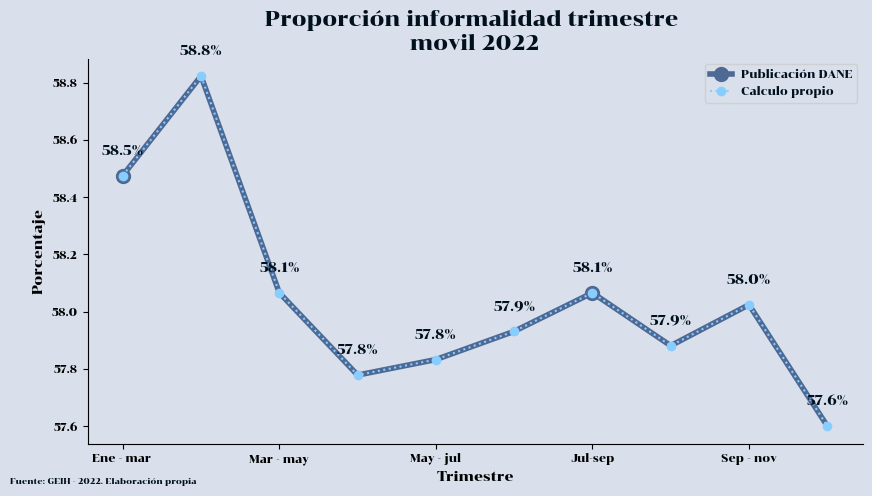

In [ ]:
''' 
El DANE presenta la información de informalidad de forma trimestre corrido, por este motivo se agrupan los resultados por trimestrre corrido usando el factor de expansión
trimestral. 

Posterior a esto se agregan los resultados DANE para tener una comparabilidad

'''
#Lista de trimestres
trimestre_movil = [["01", "02", "03"], ["02", "03", "04"], ["03", "04", "05"], ["04", "05", "06"], ["05", "06", "07"], ["06", "07", "08"], ["07", "08", "09"], ["08", "09", "10"], ["09", "10", "11"], ["10", "11", "12"]]

trim_movi = pd.DataFrame()

#Calculo trimestre corrido
for trimestre in trimestre_movil:
    resultado = df_final[(df_final['mes'].isin(trimestre)) ].groupby('ano').apply(lambda x: (1-((x['infor'] * x['fex_t']).sum() / x['fex_t'].sum()))*100 )
    trim_movi = pd.concat([trim_movi, resultado], axis=1)

trim_movi.columns = ['Ene - mar ', 'Feb - abr ', 'Mar - may', 'Abr - Jun', 'May - jul', 'Jun-ago', 'Jul-sep', 'Ago-oct', 'Sep - nov', 'Oct -dic']

trim_movi.loc['2022_DANE'] = [58.4753,	58.8231,	58.0660,	57.7784,	57.8326,	57.9312,	58.0657,	57.8810,	58.0242,	57.6005,]


#generación de linea que compare los dos resultados 

# tamaño
fig, ax = plt.subplots(figsize=(10, 5))

#transposición de la tabla 
trim_movi = trim_movi.T

# Linea de resultado DANE
trim_movi['2022_DANE'].plot(kind='line', marker='o',markevery=0.8, label='Publicación DANE', ax=ax, color = "#4E6994",linewidth=4, markersize=10)

# Línea de resultado propio
trim_movi[2022].plot(kind='line', linestyle=':', marker='o', label='Calculo propio', ax=ax, color = "#87CDFF")


# labels
plt.title('Proporción informalidad trimestre \nmovil 2022',fontsize = 15)
plt.xlabel('Trimestre',fontsize = 10)
plt.ylabel('Porcentaje',fontsize = 10)

# Puntos de datos primera línea
for i, value in enumerate(trim_movi[2022]):
    ax.annotate(f'{value:.1f}%', (i, value), textcoords="offset points", xytext=(0, 15), ha='center')

ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

# Quitar las linea vertical superior i dereha horizontal 
sns.despine()

# Display the legend
ax.legend(fontsize=8)

#nota
ax.text(-0.1, -0.1, note, transform=ax.transAxes, va='center', fontsize=6)

plt.show()


#### 4.1.2 Proporción de informalidad

Se genera un pie con la proporción de informalidad teniendo en cuenta el factor de expansión anual 

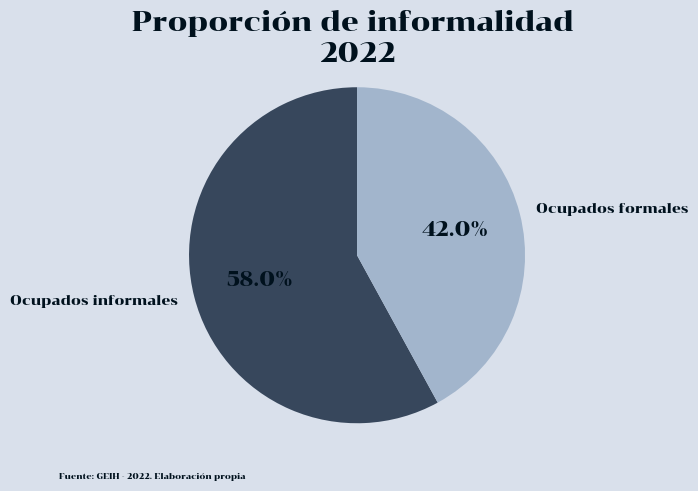

In [ ]:
#calculo propoción de informalidad 2022
plot2 = df_final[["infor","fex_a"]].groupby("infor").sum('fex_a')
plot2 = plot2['fex_a'] / sum(plot2['fex_a'])

#Labels
label = ['Ocupados informales', 'Ocupados formales']

# gráfica
fig, ax = plt.subplots()
patches, text, autotext =  ax.pie(plot2,  labels=label, autopct='%1.1f%%', startangle=90, colors =  ['#37475C', '#A2B5CC'])

# ratio
ax.axis('equal')

# titulo
ax.set_title('Proporción de informalidad \n2022', fontsize = 20)

#tamaño porcentajes
for autotext in autotext:
    autotext.set_fontsize(15)


#nota
ax.text(-0.1, -0.1, note, transform=ax.transAxes, va='center', fontsize=6)

plt.show()

#### 4.1.3 Histograma edad e informalidad

Se presenta la distribución de la edad entre los ocupados dividio por la cantidad de informales y formales

<ipython-input-46-15386583c576>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y/1000):,}' for y in ax.get_yticks()])


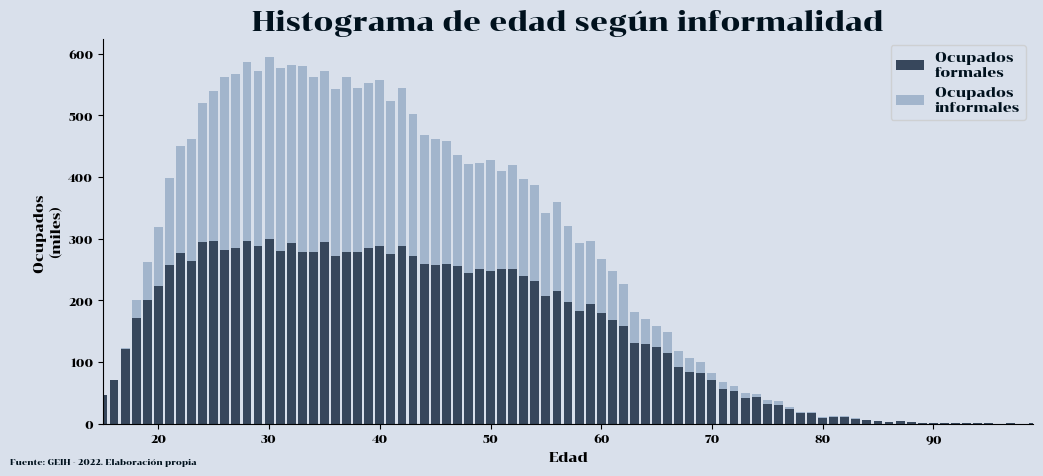

In [ ]:
plot3 = grouped_data = df_final[["p6040","infor","fex_a"]].groupby(["p6040","infor"]).sum('fex_a').reset_index()
plot3 = plot3.pivot(index='p6040', columns='infor', values='fex_a')


# tamaño
fig, ax = plt.subplots(figsize=(12, 5))



colores =  ['#37475C', '#A2B5CC']

# Definir valores de x
x = plot3.index

# Plot each stack with the specified colors
for i, col in enumerate(plot3.columns):
    label = "Ocupados \nformales" if i == 0 else "Ocupados \ninformales"
    plt.bar(x, plot3[col], bottom=plot3.iloc[:, :i].sum(axis=1), color=colores[i % len(colores)], label=label)


# labels
ax.set_xlabel('Edad')
ax.set_ylabel('Ocupados \n(miles)')
ax.set_title('Histograma de edad según informalidad',fontsize = 20)



ax.set_xlim(min(x), max(x))

#Valores de y
ax.set_yticklabels([f'{int(y/1000):,}' for y in ax.get_yticks()])

#Tamaño de letra
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

# Quitar las linea vertical superior i dereha horizontal 
sns.despine()

# Show the legend
ax.legend(loc='upper right')


#nota
ax.text(-0.1, -0.1, note, transform=ax.transAxes, va='center', fontsize=6)


# Show the plot
plt.show()

#### 4.1.4 Proporción de informalidad por grupos de edad

Se generan agrupaciones de edad según los definidos por el DANE para la muestra de la GEIH y se calcula el porcentaje de formalidad e informalidad. 

<ipython-input-57-0683c0b8c038>:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  edad_per['Total'] = edad_per.sum(axis=1)


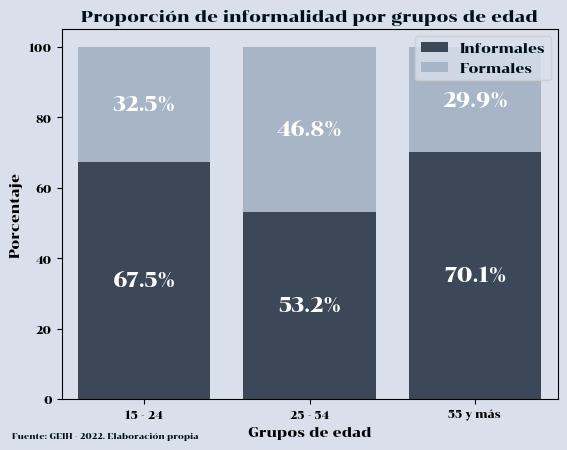

In [ ]:

# Grupos de edad del DANE
age_groups = ['15 - 24', '25 - 54', '55 y más']

# Grupos de edad como variable
df_final['age_group'] = pd.cut(df_final['p6040'], bins=[14, 24, 54, df_final['p6040'].max()], labels=age_groups)

# Calculo del porcentaje
edad_per = df_final.groupby(['age_group', 'infor'])['fex_a'].sum().unstack().reset_index()
edad_per['Total'] = edad_per.sum(axis=1)
edad_per['Formal %'] = edad_per[0] / edad_per['Total'] * 100
edad_per['Informal %'] = edad_per[1] / edad_per['Total'] * 100

# gráfica
ax = sns.barplot(data=edad_per, x='age_group', y='Formal %', color='#37475C', label='Informales')
sns.barplot(data=edad_per, x='age_group', y='Informal %', color='#A2B5CC', label='Formales', bottom=edad_per['Formal %'])


# labels
plt.title('Proporción de informalidad por grupos de edad')
plt.xlabel('Grupos de edad')
plt.ylabel('Porcentaje')

# Show the percentage values in the center of each bar
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=15, color='white')


#Tamaño de letra
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
               

# Show the legend
plt.legend()

#nota
ax.text(-0.1, -0.1, note, transform=ax.transAxes, va='center', fontsize=6)

# Show the plot
plt.show()



#### 4.1.5 Boxplot de años de educación grupos de edad e informalidas

Se preseta la distribución que tenga en cuenta los años de educación según los grupos de edad y si es informal o formal. 

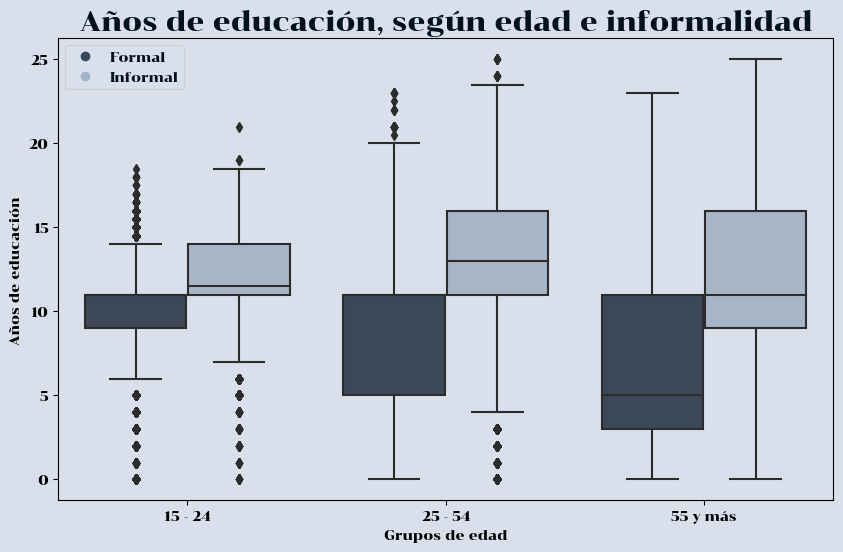

In [ ]:

# calculo de la información
grouped_data = df_final.groupby(['age_group', 'infor'])['a_educ'].apply(lambda x: np.average(x, weights=df_final.loc[x.index, 'fex_a'])).reset_index()

# boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x='age_group', y='a_educ', hue='infor', palette=colores)


# titulo
plt.title('Años de educación, según edad e informalidad',fontsize = 20 )
plt.xlabel('Grupos de edad')
plt.ylabel('Años de educación')


legend_labels = ['Formal', 'Informal']
legend_colors = colores[:len(legend_labels)]
handles = [plt.Line2D([], [], color=color, marker='o', linestyle='None') for color in legend_colors]
plt.legend(handles, legend_labels, title='', loc='best')

#nota
ax.text(-0.1, -0.1, note, transform=ax.transAxes, va='center', fontsize=6)


plt.show()


#### 4.1.5 Generación de mapas con la proporción de informalidad

Se presenta la distribución a nivel de departamentos de la proporción de informalidad 

In [ ]:
#Se descargan los SHP y demás archivos relacionados 

!wget https://raw.githubusercontent.com/caavila96/Informalidad_GEIH_2022/4b2fb379b710ad5448f1d1b37bf7a90eeb4ebb2c/SHAPE%20DPTO/MGN_DPTO_POLITICO.shp 
!wget https://raw.githubusercontent.com/caavila96/Informalidad_GEIH_2022/4b2fb379b710ad5448f1d1b37bf7a90eeb4ebb2c/SHAPE%20DPTO/MGN_DPTO_POLITICO.shx
!wget https://raw.githubusercontent.com/caavila96/Informalidad_GEIH_2022/4b2fb379b710ad5448f1d1b37bf7a90eeb4ebb2c/SHAPE%20DPTO/MGN_DPTO_POLITICO.prj
!wget https://raw.githubusercontent.com/caavila96/Informalidad_GEIH_2022/4b2fb379b710ad5448f1d1b37bf7a90eeb4ebb2c/SHAPE%20DPTO/MGN_DPTO_POLITICO.dbf

#Lectura del archivo shp (es necesario descargarlos todos)
dpto = gpd.read_file('/content/MGN_DPTO_POLITICO.shp')

--2023-05-25 21:21:14--  https://raw.githubusercontent.com/caavila96/Informalidad_GEIH_2022/4b2fb379b710ad5448f1d1b37bf7a90eeb4ebb2c/SHAPE%20DPTO/MGN_DPTO_POLITICO.shp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16321324 (16M) [application/octet-stream]
Saving to: ‘MGN_DPTO_POLITICO.shp’

MGN_DPTO_POLITICO.s 100%[===================>]  15.56M  --.-KB/s    in 0.1s    

2023-05-25 21:21:15 (136 MB/s) - ‘MGN_DPTO_POLITICO.shp’ saved [16321324/16321324]

--2023-05-25 21:21:15--  https://raw.githubusercontent.com/caavila96/Informalidad_GEIH_2022/4b2fb379b710ad5448f1d1b37bf7a90eeb4ebb2c/SHAPE%20DPTO/MGN_DPTO_POLITICO.shx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.g

In [ ]:
resultados = df_final[['mes','dpto','infor','fex_a']].groupby('dpto').apply(lambda x: (1-((x['infor'] * x['fex_a']).sum() / x['fex_a'].sum()))*100 ).reset_index()

resultados = resultados.rename(columns={0: 'informalidad'})

dpto = dpto.merge(resultados, left_on=['DPTO_CCDGO'], right_on=['dpto'], how="left")


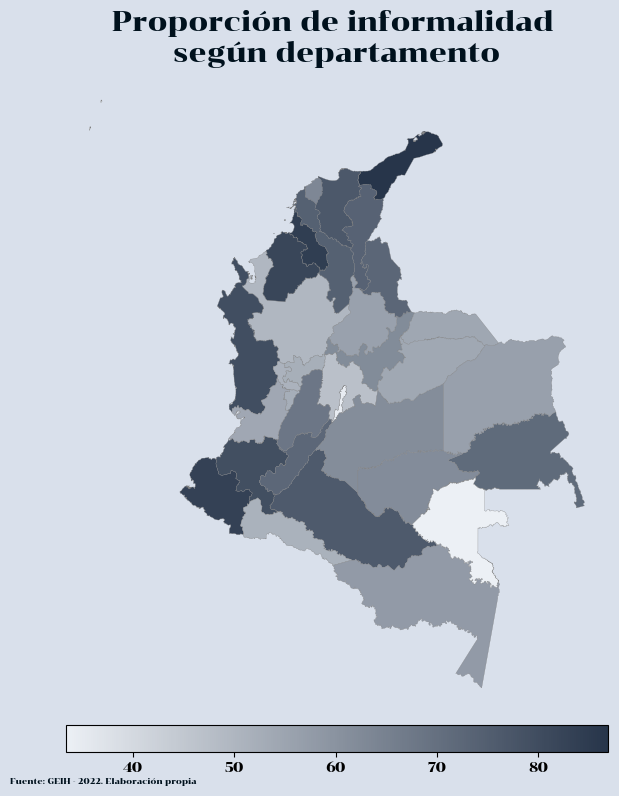

In [ ]:
# tamaño 
fig, ax = plt.subplots(figsize=(10, 10))

#Color más claro y más oscuro
colors = ['#ECF0F5', '#27354A'] 

# crear esquema de color
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', colors)

# generación del mapa
dpto.plot(ax=ax, column="informalidad",  edgecolor="#7F7F7F",  cmap= cmap, linewidth=0.2)

# quitar el marco
ax.axis('off')

#titulo 
plt.title('Proporción de informalidad \nsegún departamento',fontsize = 20 )

# Ajustar la posición de la barra de color
cbar = fig.colorbar(ax.get_children()[0], ax=ax, orientation='horizontal', pad=0.01, shrink=0.7)


#nota
ax.text(-0.1, -0.1, note, transform=ax.transAxes, va='center', fontsize=6)

plt.show()

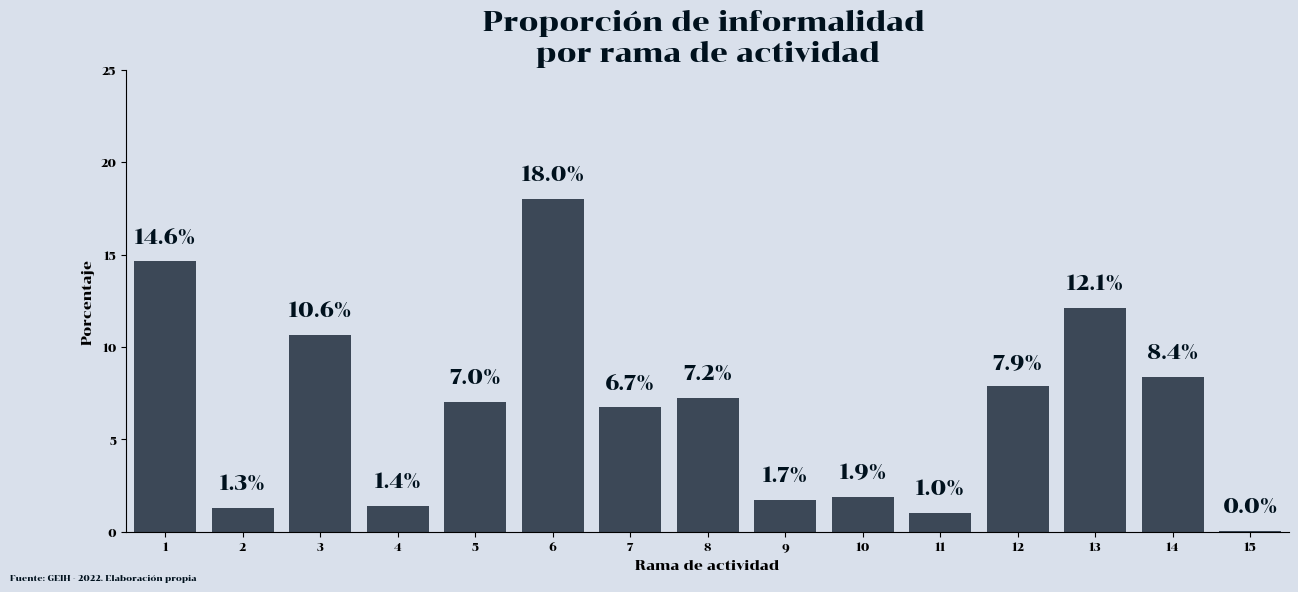

In [ ]:

# Calculo del porcentaje
rama_per = df_final.groupby('rama')['fex_a'].sum().reset_index()
rama_per['Total'] = rama_per['fex_a'].sum()
rama_per['Porcentaje'] = rama_per['fex_a'] / rama_per['Total'] * 100

fig, ax = plt.subplots(figsize=(15, 6))

# Gráfica
ax = sns.barplot(data=rama_per, x='rama', y='Porcentaje', color='#37475C')

# Quitar las linea vertical superior i dereha horizontal 
sns.despine()

# Labels
plt.title('Proporción de informalidad \npor rama de actividad', fontsize = 20 )
plt.xlabel('Rama de actividad')
plt.ylabel('Porcentaje')

# Porecentahe 
for p in ax.patches:
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + p.get_width() / 2, y + height + 1), ha='center', fontsize=15)


ax.set_ylim(0, 25)

#nota
ax.text(-0.1, -0.1, note, transform=ax.transAxes, va='center', fontsize=6)


# Tamaño de letra
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

# Show the plot
plt.show()

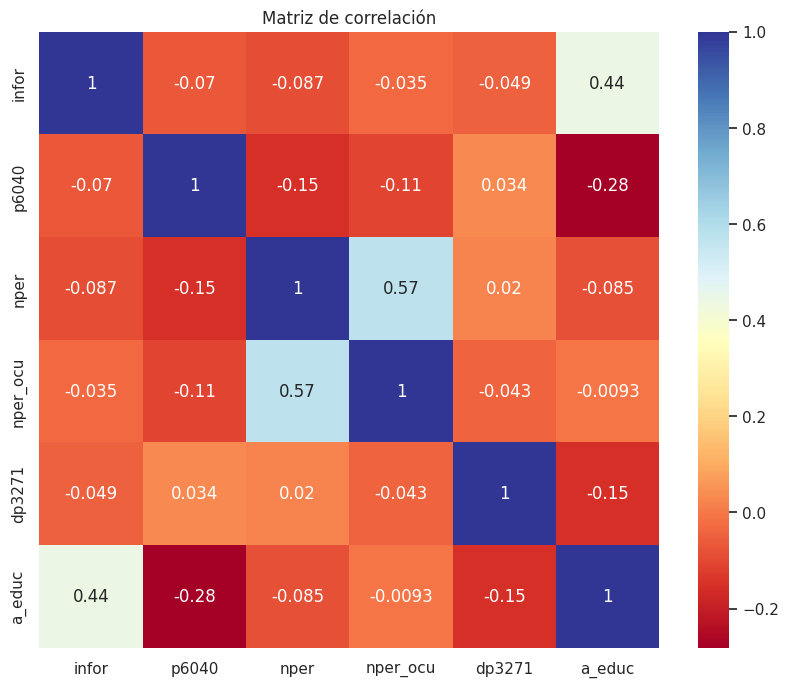

In [ ]:
# Select the variables for correlation
variables = ['infor', 'p6040', 'nper', 'nper_ocu', 'dp3271', 'a_educ']
correlation_data = df_final[variables]


# matris de correlación
correlation_matrix = correlation_data.corr()

# mapa de calor
sns.set(style='white')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu')

# titulo
plt.title('Matriz de correlación')

# plot
plt.show()

In [ ]:
correlation_data

,infor,p6040,nper,nper_ocu,dp3271,a_educ,a_educ^2,dominio,dominio_encoded
0,0,33,6,1,1,11.0,121.0,101,3
6,0,58,3,3,1,5.0,25.0,101,3
7,0,61,3,3,0,5.0,25.0,101,3
8,0,36,3,3,1,5.0,25.0,101,3
9,0,20,3,1,0,11.0,121.0,101,3
...,...,...,...,...,...,...,...,...,...
919449,1,54,4,3,1,11.0,121.0,66,20
919450,1,28,4,3,1,16.0,256.0,66,20
919452,1,43,3,1,0,13.0,169.0,101,3
919455,0,53,4,2,1,5.0,25.0,101,3


#### 4.1.2 Gráfico de barras apiladas población por trimestre 

## **5. Modelo de regresión logística**

En este apartado se mostraron los análisis y resultados luego de aplicar modelación logística a los datos de informalidad, para establecer su determinantes. Especificamente se quiere estimar una función:

$$Pr(y = informal) = F(X\beta) = \frac{e^{X\beta}}{1+e^{X\beta}}$$

> 
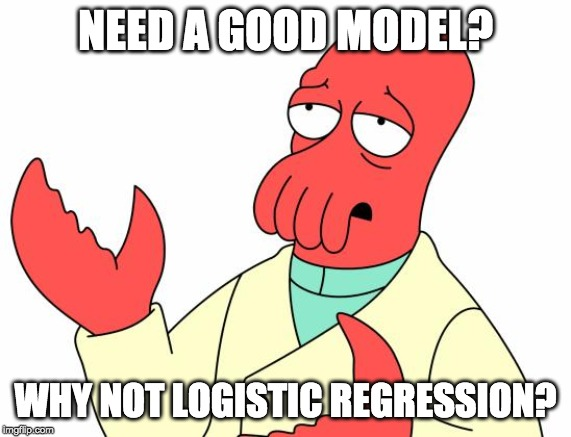

In [ ]:
#LIBRERIA:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report

### 5.1 Categorización de variables

A continuación se realiza la creación de variables dummy para las variables de rama de actividad económica y dominio (que hace referencia a las ciudades capitales de departamento, area rural y resto urbano). Una vez realiza este depuración, se crea la variable dependiente de informalidad, y, y las covariable que harán parte de la regresión logística.

In [ ]:
#COVARIABLES:
cov  = ['infor','const','p6040','p6040^2','nper','nper_ocu','dp3271','a_educ','a_educ^2','p3069','dominio','ramastr']
logi = pd.get_dummies(df_final[cov].dropna()).drop(['dominio_11','ramastr_3'], axis=1)
y    = logi[logi.columns[0]].map(lambda formal: 1-formal).astype(np.int8)
x    = logi[logi.columns[1:]].astype(np.float32)

### 5.2 Estimación de **modelo**

El modelo muestra, signficancia en variables claves como la educación, edad y el tamaño de la empresa. Se destaca que cuando se incluye el componente cuadratico en la edad y educación, estos presentan significacia igualmente, dado que su p-value es de 0.000.  Esto, evidencia que el ajuste con estas variables no es propiamente lineal (un poco a como se mostró en la descriptiva de edad e informlaidad). Así mismo, el sexo presenta significancia, evidenciando diferencia entre hombre y mujeres, y las dummy's de rama y dominios, también presentado significancia, con algunas excepciones. 


In [ ]:
#LOGISTIC REGRESSION: RESULTADOS MUESTRA
out = sm.Logit(y,x).fit().summary()
print(out)

Optimization terminated successfully.
         Current function value: 0.314561
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  infor   No. Observations:               382450
Model:                          Logit   Df Residuals:                   382402
Method:                           MLE   Df Model:                           47
Date:                Thu, 25 May 2023   Pseudo R-squ.:                  0.5371
Time:                        19:55:57   Log-Likelihood:            -1.2030e+05
converged:                       True   LL-Null:                   -2.5989e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.9055      0.069     85.595      0.000       5.770       6.041
p6040          -0.0994    

In [ ]:
#COEFICIENTES:
out_as_html   = out.tables[1].as_html()
tabla_as_html = pd.read_html(out_as_html, header=0, index_col=0)[0]
tabla_as_html

,coef,std err,z,P>|z|,[0.025,0.975]
const,5.9055,0.069000,85.595,0.000,5.770,6.041
p6040,-0.0994,0.002000,-42.301,0.000,-0.104,-0.095
p6040^2,0.0009,0.000027,34.613,0.000,0.001,0.001
nper,0.0495,0.004000,12.849,0.000,0.042,0.057
nper_ocu,-0.0052,0.007000,-0.738,0.461,-0.019,0.009
dp3271,-0.2105,0.012000,-18.207,0.000,-0.233,-0.188
a_educ,-0.0794,0.006000,-13.942,0.000,-0.091,-0.068
a_educ^2,-0.0022,0.000000,-7.818,0.000,-0.003,-0.002
p3069,-0.6341,0.002000,-272.783,0.000,-0.639,-0.630
dominio_05,-0.1851,0.037000,-5.041,0.000,-0.257,-0.113


In [ ]:
#LOGISTIC REGRESSION: RESULTADOS EXPANDIDO
df_final['formal'] = df_final.infor.map(lambda formal: 1 - formal)
weight = df_final[cov+['fex_a','formal']].dropna().groupby('formal').sum()['fex_a'].to_dict()
lr_sample = lr(penalty=None).fit(x,y)
lr_weight = lr(class_weight = weight, penalty=None).fit(x,y)

## Comparativo expandido vs muestra:

El comparativo entre las estimaciones con factor de expansión y muestra, evidencia que no existe diferencias marcadas entre ambos tipos de estimacions. En algunos casos, la expansión corrige los valores de los coeficientes (normalizados), pero no presentando diferencias tan grnade.

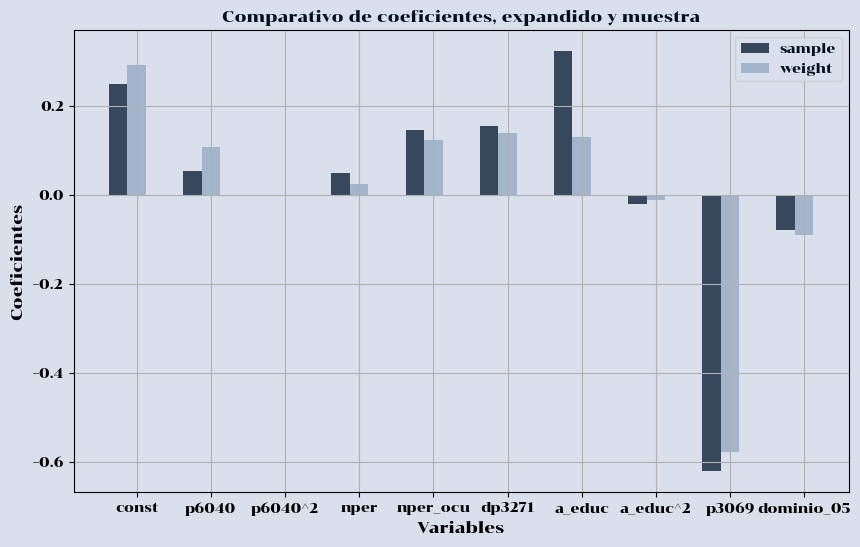

In [ ]:
#RESULTADOS COMPARATIVOS:

#width: 
fig = plt.subplots(figsize =(10, 6))
barWidth = 0.25

#height:
bar1 = lr_sample.coef_[0][:10]
bar2 = lr_weight.coef_[0][:10]
 
# posición x's:
br1 = np.arange(len(bar1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
#plot:
plt.bar(br1, bar1, width = barWidth, label ='sample',color =  ['#37475C'])
plt.bar(br2, bar2, width = barWidth, label ='weight',color =  ['#A2B5CC'])
 
# xticks:
plt.xlabel('Variables',   fontweight ='bold', fontsize = 12)
plt.ylabel('Coeficientes',fontweight ='bold', fontsize = 12)
plt.title('Comparativo de coeficientes, expandido y muestra', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bar1))], logi.columns[1:11])
 
plt.legend()
plt.grid(True)
plt.show()

### 5.3 Medida clasificación

A pesar de que el proposito del trabajo no es realizar un modelo de aprendizaje enfocado a pronosticos/predicciones, se realizó el cálculo de métricas de ajustes de modelos. Por un lado, el pseudo r2 estuvo alrededor de los 0.53 puntos, y las medidas de preicisión y recall, mostraron que  la estimación de las personas informales en el modelo fueron altas.

In [ ]:
#REPORTE CLASIFICACION:
pr = lr_sample.predict(x)
print("En los datos de entrenamiento \n",classification_report(y, pr))

En los datos de entrenamiento 
               precision    recall  f1-score   support

           0       0.89      0.78      0.83    159759
           1       0.86      0.93      0.89    222691

    accuracy                           0.87    382450
   macro avg       0.88      0.86      0.86    382450
weighted avg       0.87      0.87      0.87    382450



In [ ]:
confusion_matrix(y, pr)

array([[125312,  34447],
       [ 15106, 207585]])

### 5.4 Ajuste logistico

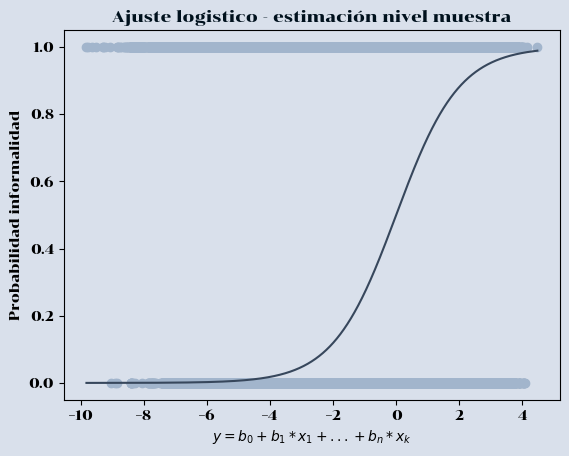

In [ ]:
#PROBABILIDAD INFORMALIDAD VS Y PREDICHO:
y_gorro = np.sort((lr_sample.coef_[0]*x).sum(axis=1))
pr_muestra = np.exp(y_gorro)/(1+np.exp(y_gorro))

plt.plot(y_gorro,pr_muestra, color = '#37475C')
plt.scatter(y_gorro,y,color = '#A2B5CC')
plt.title('Ajuste logistico - estimación nivel muestra')
plt.ylabel('Probabilidad informalidad')
plt.xlabel('$y = b_0 + b_1*x_1 + ... + b_n*x_k$')
plt.show()

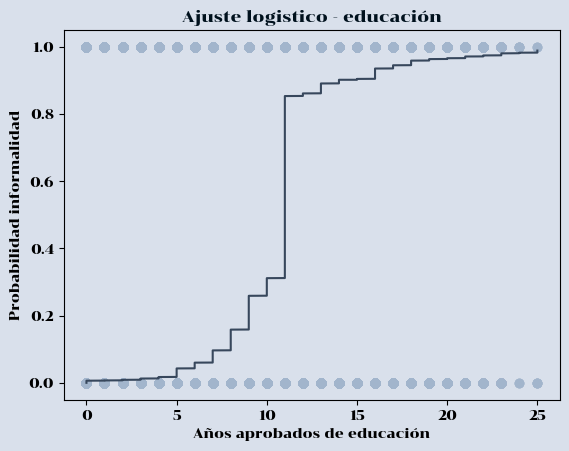

In [ ]:
#PROBABILIDAD INFORMALIDAD VS Educación:
y_gorro = np.sort(logi['a_educ']).astype(np.int32)

plt.plot(y_gorro,pr_muestra, color = '#37475C')
plt.scatter(y_gorro,y,color = '#A2B5CC')
plt.title('Ajuste logistico - educación')
plt.ylabel('Probabilidad informalidad')
plt.xlabel('Años aprobados de educación')
plt.show()

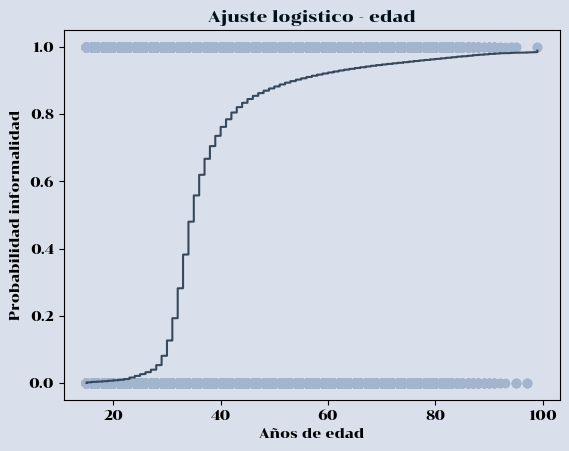

In [ ]:
#PROBABILIDAD INFORMALIDAD VS Edad:
y_gorro = np.sort(logi['p6040']).astype(np.int32)

plt.plot(y_gorro,pr_muestra, color = '#37475C')
plt.scatter(y_gorro,y,color = '#A2B5CC')
plt.title('Ajuste logistico - edad')
plt.ylabel('Probabilidad informalidad')
plt.xlabel('Años de edad')
plt.show()